Basically the same as exact_diagonalization_analysis but for larger systems obtained with MPS

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import h5py
import json
import matplotlib 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import sys  

from ast import literal_eval

from qutip import  *

sys.path.append('../../scripts') 

from qutip_tools import *


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# define basic figure sizes
bwidth=7
bheight=5
base_font = 20

matplotlib.rcParams.update({'font.size': base_font,"legend.fontsize":base_font-4 ,"font.family": "serif", 
                            "font.serif": "CMU Serif, Times New Roman",
                           'text.usetex' : True })

sns.set_palette("colorblind")

fig_route = "../../plots/QPC_double_dot/"


In [3]:
ll=100
data_route = "../../data/MPS/L={}/".format(ll)

J=1


# Checking hitting conditions

In [4]:
file_list = get_file_names_on(["TEBD2","om{}_".format(0.3), "Del{}_".format(6.0),"t{}".format(0.05)], data_route)
print(file_list)
TEBD_params, TEBD_times, TEBD_occ, TEBD_bond_dim, TEBD_entropies, TEBD_qubit_rho  = load_MPS(data_route, 
                                                                                             file_list[0]) 


['TEBD2_L100_J1.0_t0.05_om0.3_Del6.0_xo25_k0.7854_bindex50_maxtau70.71067811865476_tstep0.07_cutoff-18_fixed_theta0.9425_phi0.0.h5', 'TEBD2_L100_J1.0_t0.05_om0.3_Del6.0_xo25_k1.414_bindex50_maxtau50.623256289400146_tstep0.07_cutoff-18_fixed_theta0.9425_phi0.0.h5', 'TEBD2_L100_J1.0_t0.05_om0.3_Del6.0_xo25_k1.571_bindex50_maxtau50.0_tstep0.07_cutoff-18_fixed_theta0.9425_phi0.0.h5', 'TEBD2_L100_J1.0_t0.05_om0.3_Del6.0_xo25_k0.9425_bindex50_maxtau61.80339887498948_tstep0.07_cutoff-18_fixed_theta0.9425_phi0.0.h5', 'TEBD2_L100_J1.0_t0.05_om0.3_Del6.0_xo25_k1.1_bindex50_maxtau56.11631188171805_tstep0.07_cutoff-18_fixed_theta0.9425_phi0.0.h5', 'TEBD2_L100_J1.0_t0.05_om0.3_Del6.0_xo25_k1.257_bindex50_maxtau52.573111211913364_tstep0.07_cutoff-18_fixed_theta0.9425_phi0.0.h5', 'TEBD2_L100_J1.0_t0.05_om0.3_Del6.0_xo25_k0.4712_bindex50_maxtau110.13446322926335_tstep0.07_cutoff-18_fixed_theta0.9425_phi0.0.h5', 'TEBD2_L100_J1.0_t0.05_om0.3_Del6.0_xo25_k0.6283_bindex50_maxtau85.06508083520399_tstep0.07

Text(0.5, 0, 'Time')

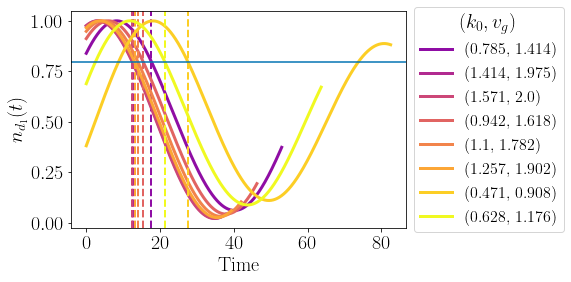

In [5]:
colors = plt.cm.plasma(np.linspace(0.3,1,len(file_list)))

fig, ax = plt.subplots(figsize=(6,4))

for i in range(0,len(file_list)):
    file_name = file_list[i]
    TEBD_params, TEBD_times, TEBD_occ, TEBD_bond_dim, TEBD_entropies, TEBD_qubit_rho  = load_MPS(data_route, 
                                                                                             file_list[i]) 
    # calculate the time it takes it to hit the bond (scattering approx)
    vg = 2*np.sin(TEBD_params["k0"])
    tau_to_bond = (TEBD_params["bond_index"]-TEBD_params["x0"])/vg
    
    lab = "("+str(round(TEBD_params["k0"],3)) + ", " + str(round(vg,3))+")" 
    
    plt.plot(TEBD_times, TEBD_occ[:,-2], linewidth=3, label=lab , c=colors[i])
    
    plt.axvline(tau_to_bond, linestyle="dashed",c=colors[i], linewidth=2)    
    
plt.axhline(np.cos(TEBD_params["qubit_theta"]/2)**2)
    
plt.legend(title=r"$(k_0, v_g)$",loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel(r"$n_{d_1}(t)$")
plt.xlabel(r"Time")

# Create dataframe for analysis

In [56]:
MPS_file_list = get_file_names_on([""], data_route) # get all filenames for mps
# load some file to get the parameters since all are the same
MPS_params, _, _, _, _, _  = load_MPS(data_route, MPS_file_list[0])
print(len(MPS_file_list))

89


In [70]:
# read the parameter dictionary to initialize 
param_dict, _, _, _, _, _  = load_MPS(data_route, MPS_file_list[0])

data_dict =  {key: [] for key in param_dict}
data_dict["times"] = []
data_dict["occupations"] = []
data_dict["d0_density"] = []
data_dict["qubit_rho"] = []
data_dict["entropy"] = []
data_dict["time_at_bond"] = []
data_dict["Max_entropy"] = []
data_dict["cos_theta"] = []
data_dict["sin_phi"] = []
data_dict["bond_dimension"] = []

for i in range(0,len(MPS_file_list)):
    file_name = MPS_file_list[i]
    param_dict, times, occupations, bond_dim, entropy, qubit_rho = load_MPS(data_route, file_name) 
    occupations = occupations.T
    # initialize the meta data
    for key in param_dict.keys():
        data_dict[key].append(param_dict[key])

    #  estimate the time that wavepacket spends at bondf
    bond_density = occupations[param_dict["bond_index"], :] + occupations[param_dict["bond_index"]+1, :]
    tau_bond = get_time_at_bond(times, bond_density)
    
    # get the bloch angles fo the qubit
    theta_list, phi_list = get_bloch_angles_time(qubit_rho)

    # save raw data 
    data_dict["times"].append(list(times.astype(np.float32)))
    data_dict["occupations"].append(occupations[:-2,:].astype(np.float32))
    data_dict["d0_density"].append(occupations[-2:,:].astype(np.float32)) 
    data_dict["qubit_rho"].append(qubit_rho.astype(np.complex64))
    # normalize entropy by maximally entangled singled 
    data_dict["entropy"].append(list((entropy/np.log(2)).astype(np.float32)))
    # save processed data
    data_dict["time_at_bond"].append(tau_bond)
    data_dict["Max_entropy"].append(max(entropy/np.log(2)))
    data_dict["cos_theta"].append(theta_list)
    data_dict["sin_phi"].append(phi_list)
    data_dict["bond_dimension"].append(bond_dim.astype(np.float32))

data_df = pd.DataFrame.from_dict(data_dict)
# rename the columns so we have the same comnventions as in exact diagonalziation
data_df = data_df.rename(columns={'x0': 'X0', 'k0': 'K0', 'spread':'Spread', "L":"L_qpc",
                                'time_step':'del_tau', 'qinit':'qubit_init', "qubit_theta":"alfabond", "qubit_phi":"phi"})

data_df.to_csv("../../data/exp_pro/TEBD_data_L={}.csv".format(ll))

# Phase Diagram

In [55]:
Om_ = 0.3 
x0_ = 25
t_ = 0.1

af = data_df["alfabond"].sort_values().unique()[0]
print(data_df["alfabond"].sort_values().unique())
# filter out for the parameters we want 
cond_ = (data_df["Omega"]==Om_) & (data_df["t"]==t_)  & (data_df["X0"]==x0_)  & (data_df["alfabond"]==af)
curr_df = data_df[cond_].sort_values(by="K0")
K0_unique = curr_df["K0"].unique()
colors = plt.cm.inferno(np.linspace(0.0,0.9,len(K0_unique)))

[0.9424778]


In [40]:
print(data_df["L_qpc"].unique())
LL = data_df["L_qpc"].unique()[0]
J = data_df["J"].unique()[0]


[100]


In [38]:
print("Density at bond when hit")
print(np.cos(af/2)**2)
# filter out for the parameters we want 
cond_ = (data_df["evol_type"]=="TEBD2") & (data_df["Omega"]==Om_) & (data_df["t"]>0.0001) & (data_df["qubit_init"]=="fixed") & (data_df["X0"]==x0_) & (data_df["alfabond"]==af)

data_S = data_df[cond_].sort_values(by="K0")

S_df = data_S.pivot(index='K0', columns='t', values='Max_entropy')
S_df

Density at bond when hit
0.7938926261462367


t,0.001,0.010,0.030,0.050,0.070,0.100,0.300,0.500,0.800,1.000,2.000
K0,,,,,,,,,,,
0.471239,0.389329,0.433809,0.443956,0.430664,0.413170,0.380209,0.173941,0.143526,0.116709,0.105069,0.006299
0.628319,0.295227,0.314504,0.334742,0.330741,0.322119,0.316005,0.160063,0.116407,0.095755,0.085272,0.006143
0.785398,0.232954,0.241478,0.254900,0.258633,0.256102,0.250707,0.209629,0.098791,0.080252,0.073057,0.006120
0.942478,0.193427,0.197783,0.205507,0.209414,0.209626,0.206083,0.214769,0.124745,0.070523,0.066461,0.006058
1.099557,0.168394,0.170992,0.175716,0.178530,0.179277,0.177262,0.176368,0.168811,0.068155,0.065816,0.005967
1.256637,0.153018,0.154815,0.158059,0.160060,0.160711,0.159382,0.146726,0.162604,0.097294,0.073772,0.005931
1.413717,0.144659,0.146098,0.148660,0.150227,0.150734,0.149623,0.131637,0.139958,0.146888,0.098702,0.005896
1.570796,0.142005,0.143340,0.145704,0.147138,0.147590,0.146525,0.127148,0.132229,0.166586,0.117423,0.005887


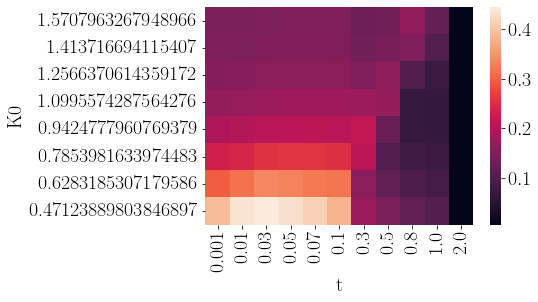

In [39]:
fig, ax = plt.subplots(1,1)
sns.heatmap(S_df)
ax.invert_yaxis()

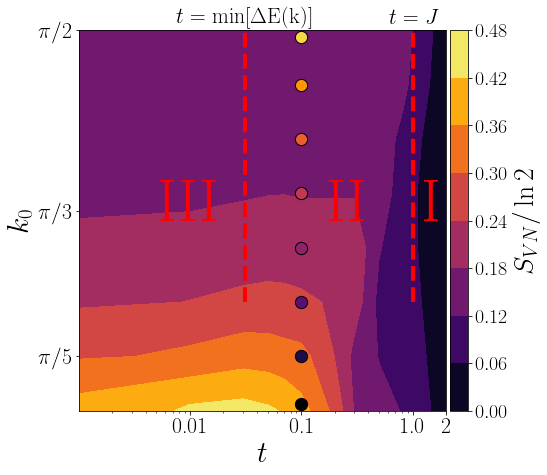

In [52]:
fig, ax = plt.subplots(1,1,figsize=(bwidth+1,bwidth))

vg_array = S_df.index
t_array = S_df.columns
im = ax.contourf(t_array, vg_array, S_df.values, cmap="inferno")
plt.xscale('log')

# Add anotate the regions
y_tick = np.pi/2 -0.04
ax.annotate(
    r'$t=\rm{min}[ \Delta E(k)]$', 
    xy=(np.pi/(LL+1), y_tick), 
    xytext=(np.pi/(LL+1), y_tick + 0.06), fontsize=22,ha='center')
ax.annotate(
    r'$t=J$', 
    xy=(J, y_tick), 
    xytext=(J, y_tick + 0.06), fontsize=22,ha='center')

# Add the labels for each region
ax.annotate('II', xy=(0.2+np.pi/50, 0.65*np.pi/2), 
            xytext=(0.2+np.pi/50, 0.65*np.pi/2),ha='center', c="red", fontsize= 60,fontweight='bold')

ax.annotate('III', xy=(0.01, 0.65*np.pi/2), 
            xytext=(0.01, 0.65*np.pi/2),ha='center', c="red", fontsize= 60,fontweight='bold')

ax.annotate('I', xy=(1.5, 0.65*np.pi/2), 
            xytext=(1.5, 0.65*np.pi/2),ha='center', c="red", fontsize= 60,fontweight='bold')

ax.vlines([np.pi/(LL+1), J], ymin=0.5*np.pi/2, ymax=np.pi/2, color='red', lw=4, linestyle="dashed", clip_on=False)  # tick-like line

# add scatterplot points by hand
ax.scatter(t_, K0_unique[0]+0.02, s=150, edgecolor="black",color=colors[0])

for ki in range(1,len(K0_unique)-1):
    ax.scatter(t_, K0_unique[ki], s=150, edgecolor="black",color=colors[ki])
    
ax.scatter(t_, K0_unique[-1]-0.02, s=150, edgecolor="black",color=colors[-1])



ax.set_xticks( [0.01,0.1,1.0,2], [0.01,0.1,1.0,2] ,fontsize=22)
ax.set_yticks( [np.pi/5,np.pi/3,np.pi/2], labels=[r"$\pi/5$",r"$\pi/3$",r"$\pi/2$"],fontsize=22 )

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax, shrink=0.9)   
cbar.ax.set_ylabel(r'$S_{VN}/\ln{2}$', rotation=90, fontsize=28)

ax.set_ylabel(r"$k_0$",fontweight='bold',fontsize=30)
ax.set_xlabel(r"$t$",fontweight='bold',fontsize=30)

plt.tight_layout()

#plt.savefig(fig_route+"entropy_phase_diagram_MPS.pdf",transparent=True)

# Entropy production

## As a function of time for fixed $t$

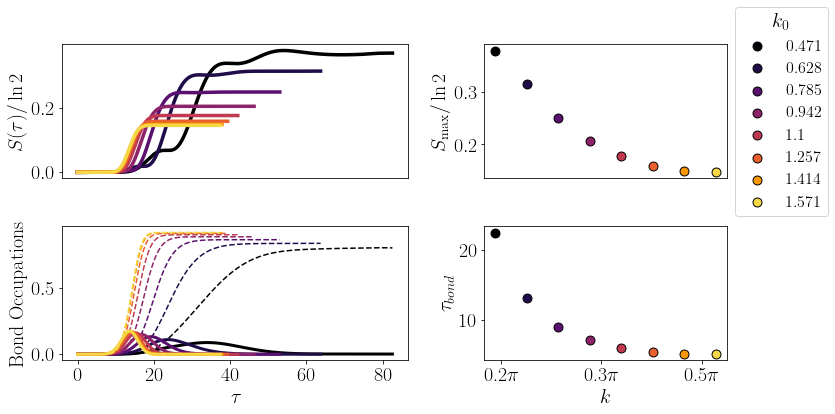

In [33]:
# Create 2x2 sub plots

fig = plt.figure(figsize=(12,6))

#plt.suptitle(om_s + ", " + bw_s + ", " + t_s )
gs = gridspec.GridSpec(2, 2, width_ratios=[1,0.7])


for i in range(0,len(K0_unique)):
    # generate the legend
    lab = str(round(K0_unique[i],3))
    # Entropy in time
    ax = plt.subplot(gs[0, 0]) # make it span both columns
    xvals = curr_df[curr_df["K0"]== K0_unique[i]]["times"].item()
    yvals = curr_df[curr_df["K0"]== K0_unique[i]]["entropy"].item()
    ax.plot(xvals,yvals, linewidth=3.5, c=colors[i])
    
    # max entropy
    ax = plt.subplot(gs[0, 1])
    ax.scatter(K0_unique[i], max(yvals), c=[colors[i]], s=80, edgecolor='black', zorder=7,label=lab)
    
    # plot density at the bond in time and transmission
    bindex = curr_df[curr_df["K0"]== K0_unique[i]]["bond_index"].item()
    occ_matrix = curr_df[curr_df["K0"]== K0_unique[i]]["occupations"].item()
    bond_density = occ_matrix[bindex, :] + occ_matrix[bindex+1, :] 
    transmission = np.sum(occ_matrix[bindex+2:,:], axis=0)
    
    ax = plt.subplot(gs[1, 0]) # row 1, col 0
    ax.plot(xvals,bond_density, linewidth=3, c=colors[i])    
    ax.plot(xvals, transmission, linestyle="dashed", linewidth=1.5, c=colors[i])
    # plot time spent at bond
    ax = plt.subplot(gs[1, 1]) # row 1, col 1
    ax.scatter(K0_unique[i], curr_df[curr_df["K0"]== K0_unique[i]]["time_at_bond"], c=[colors[i]], s=80, edgecolor='black', zorder=7)



# Set up labels and legends
plt.subplot(gs[0, 0]).set_ylabel(r"$S(\tau)/\ln{2}$")
plt.subplot(gs[0, 0]).set_xticks([])

plt.subplot(gs[0, 1]).set_xticks([])
plt.subplot(gs[0, 1]).set_ylabel(r"$S_{\rm{max}}/\ln{2}$")
# plt.subplot(gs[0, 1]).legend(title=r"$k_0$", loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.legend(title=r"$k_0$", loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.subplot(gs[1, 0]).set_ylabel(r"Bond Occupations")
plt.subplot(gs[1, 0]).set_xlabel(r"$\tau$")

plt.subplot(gs[1, 1]).set_ylabel(r"$\tau_{bond}$")
plt.subplot(gs[1, 1]).set_xlabel(r"$k$")
# write x axis in units of pi
plt.subplot(gs[1, 1]).xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))

plt.subplots_adjust(wspace=0.16, hspace=0.09)

plt.tight_layout()

## Maximum entropy as a function of $t$ for fixed $k_0$

<Axes: xlabel='t', ylabel='Max_entropy'>

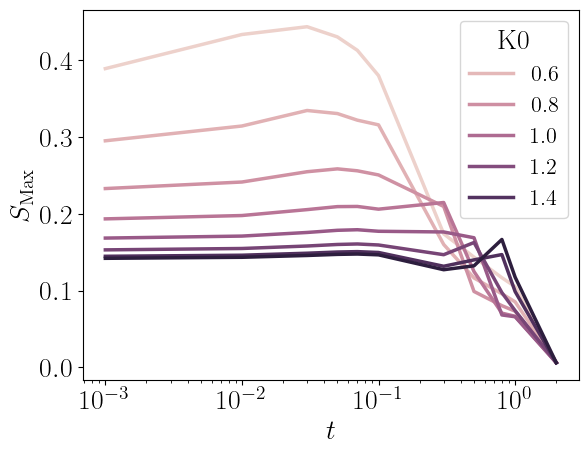

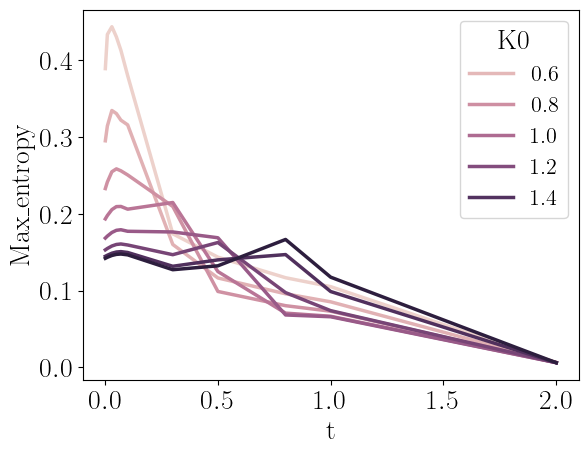

In [63]:
cond_ = (data_df["Omega"]==Om_)  & (data_df["X0"]==x0_) & (data_df["alfabond"]==af)
curr_df = data_df[cond_]

plt.figure()
sns.lineplot(data=curr_df, x="t", y="Max_entropy", hue="K0", linewidth=2.5)
plt.xscale('log')
plt.ylabel(r"$S_{\rm{Max}}$")
plt.xlabel(r"$t$")


plt.figure()
sns.lineplot(data=curr_df, x="t", y="Max_entropy", hue="K0", linewidth=2.5)


# Single Cases

In [93]:
k0_list = np.sort(data_df["K0"].unique())
print(k0_list)
k0_ = k0_list[-4]

print(Om_, t_, k0_)

# filter out for the parameters we want 
cond_ = (data_df["Omega"]==Om_) & (data_df["t"]==t_) & (data_df["K0"]==k0_)  & (data_df["X0"]==x0_)
curr_df = data_df[cond_]
curr_df

[0.4712389  0.62831853 0.78539816 0.9424778  1.09955743 1.25663706
 1.41371669 1.57079633]
0.3 0.1 1.0995574287564276


,Omega,X0,computation_time,L_qpc,cutoff,t,bond_index,max_time,K0,qubit_init,...,times,occupations,d0_density,qubit_rho,entropy,time_at_bond,Max_entropy,cos_theta,sin_phi,bond_dimension
62,0.3,25,1060.585971,100,1.000000e-18,0.1,50,56.116312,1.099557,fixed,...,"[0.0, 0.07, 0.14, 0.21, 0.28, 0.35, 0.42, 0.49...","[[1.05818625e-08, 8.28273e-09, 6.4073786e-09, ...","[[0.35580668, 0.3625232, 0.36926663, 0.3760357...","[[[(0.64419323+5.8633653e-16j), (-4.510281e-16...","[3.8441116e-15, 1.4608198e-11, 6.115919e-11, 1...",6.005246,0.177262,"[(0.2883865157499854+1.1726730697603216e-15j),...","[(0.9999998555181461+5.362501663312706e-17j), ...","[116.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0..."


## Wavefunction

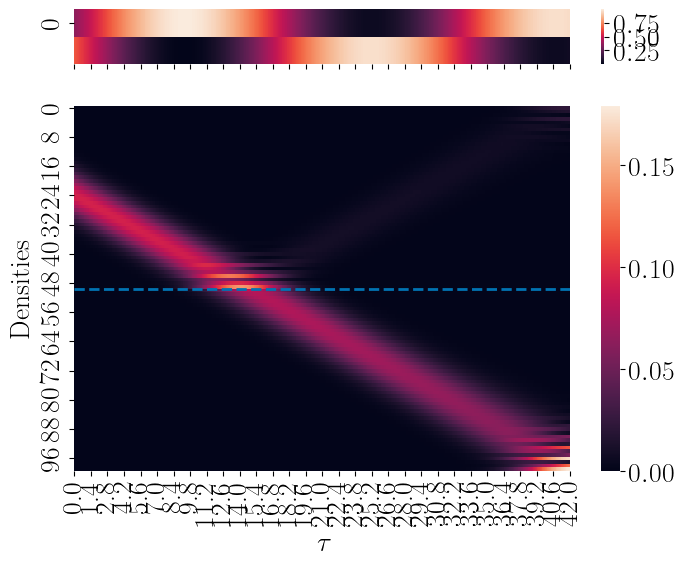

In [94]:
fig, ax = plt.subplots(2,1,figsize=(8,6), sharex=True ,gridspec_kw={'height_ratios': [0.15, 1]})

# n_d1
n_d0 = curr_df["d0_density"].item()[0]
n_d1 = curr_df["d0_density"].item()[1]
sns.heatmap([n_d0,n_d1],ax=ax[0])
traj_matrix = curr_df["occupations"].item()
time_range = curr_df["times"].item()
sns.heatmap(traj_matrix,ax=ax[1])

ax[1].set_xlabel(r"$\tau$")

ax[1].set_ylabel("Densities")

# time ticks
delta_tau = time_range[1] - time_range[0]
tick_posx = np.arange(0,len(time_range),20)
xtick_label = np.around(tick_posx*(delta_tau),decimals=1)

ax[1].axhline(curr_df["bond_index"].item(), linewidth=2, linestyle="dashed")
ax[1].set_xticks(tick_posx,xtick_label);

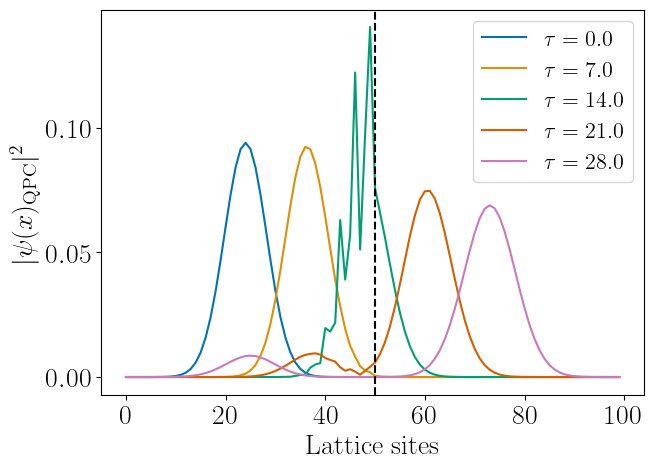

In [95]:
fig, ax = plt.subplots(1,1,figsize=(bwidth,bheight))

plt.plot(traj_matrix[:,0], label=r"$\tau={:.3}$".format(time_range[0]))
plt.plot(traj_matrix[:,100], label=r"$\tau={:.3}$".format(time_range[100]))
plt.plot(traj_matrix[:,200], label=r"$\tau={:.3}$".format(time_range[200]))
plt.plot(traj_matrix[:,300], label=r"$\tau={:.3}$".format(time_range[300]))
plt.plot(traj_matrix[:,400], label=r"$\tau={:.3}$".format(time_range[400]))

plt.axvline(ll/2, c="black", linestyle="dashed")
plt.xlabel("Lattice sites")
plt.ylabel(r"$|\psi (x)_{\rm{QPC}}|^2$")
plt.legend()

## BLoch Sphere

In [96]:
costheta = curr_df["cos_theta"].item()
sinphi = curr_df["sin_phi"].item()
ϕ0 = curr_df["phi"].item()
time_range = curr_df["times"].item()
bindex = curr_df["bond_index"].item()
rhot = curr_df["qubit_rho"].item()

τbond = bindex/(2*J*np.sin(k0_))
cosθ0 = costheta[0]

Index(['Omega', 'X0', 'computation_time', 'L_qpc', 'cutoff', 't', 'bond_index',
       'max_time', 'K0', 'qubit_init', 'Spread', 'alfabond', 'J', 'evol_type',
       'del_tau', 'type', 'phi', 'times', 'occupations', 'd0_density',
       'qubit_rho', 'entropy', 'time_at_bond', 'Max_entropy', 'cos_theta',
       'sin_phi', 'bond_dimension'],
      dtype='object')

In [98]:
rho_free_list = [rhot[0]]
theta_free_list = [np.arccos(np.real(cosθ0))]
phi_free_list = [ϕ0]

# calculate the free qubit bloch angles as a funciton of time
# by using the rotaiton matrix of the free dynamics

for i in range(1,len(time_range)):
    # rotate up to time tau
    τ = time_range[i] 
    rho_tau = rotate_rho(rho_free_list[0], τ, t_ , ϕ0)
    # get the angles at that tau
    Cos_theta_p, Sin_phi_p = get_bloch_angles(rho_tau)
    
    rho_free_list.append(rho_tau)
    theta_free_list.append(np.arccos(Cos_theta_p))
    phi_free_list.append(np.arcsin(Sin_phi_p))


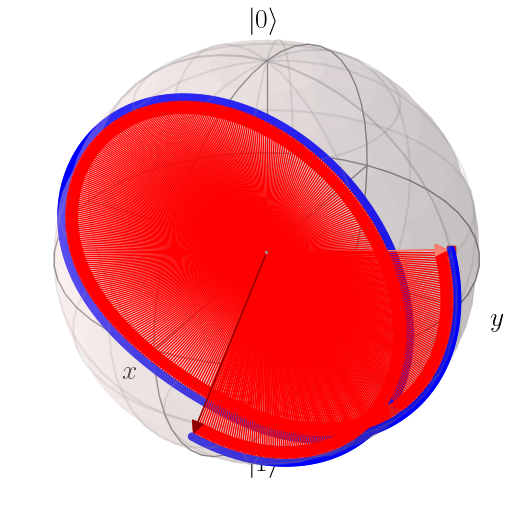

In [101]:
# Now plot the numerical coupled case
dd_theta = np.arccos(costheta)
dd_phi = np.arcsin(sinphi)

x_ = np.sin(dd_theta)*np.cos(dd_phi)
y_ = np.sin(dd_theta)*np.sin(dd_phi)
z_ = np.asarray(costheta)

coupled_vectors = [[i,j,k] for i,j,k in zip(x_.real,y_.real,z_.real)]
# make all vectors the same color

# writting out free case solution in spherical coordinates
x_free = np.sin(theta_free_list)*np.cos(phi_free_list)
y_free = np.sin(theta_free_list)*np.sin(phi_free_list)
z_free = np.cos(theta_free_list)

free_points = [x_, y_, z_]
free_first= [x_[0], y_[0], z_[0]] # first point for different color

bs = Bloch()

bs.add_vectors(coupled_vectors)
# now plot the first and last vectors and points in a different color
bs.add_vectors(coupled_vectors[0])
bs.add_vectors(coupled_vectors[-1])
bs.vector_color = ["red"]*len(coupled_vectors) + ["salmon", "darkred"]
bs.vector_width = 1.0

# now add the free vectors
bs.add_points(free_points)
bs.add_points(free_first)

#bs.view = [-20, 30]  

bs.show()

Text(0.5, 0, '$\\tau$')

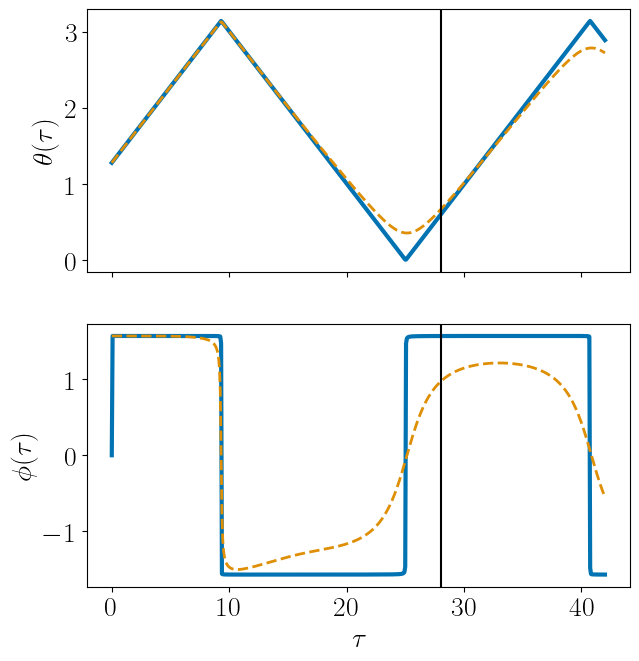

In [105]:
fig, ax = plt.subplots(2,1,figsize=(bwidth,1.5*bheight), sharex = True)

ax[0].plot(time_range, np.real(theta_free_list), linewidth=3)
ax[0].plot(time_range, np.real(dd_theta), linewidth=2.0, linestyle="dashed")
ax[0].axvline(τbond, c="black")

ax[1].plot(time_range, np.real(phi_free_list), linewidth=3 )
ax[1].plot(time_range, np.real(dd_phi),linewidth=2.0, linestyle="dashed")
ax[1].axvline(τbond,c="black")

ax[0].set_ylabel(r"$\theta (\tau)$")
ax[1].set_ylabel(r"$\phi (\tau)$")
ax[1].set_xlabel(r"$\tau$")